In [11]:
# Cell 1: Setup
!pip install --upgrade pip
!pip uninstall -y transformers tokenizers accelerate -q

!pip install "transformers==4.56.0" "protobuf>=5.29.4" -q
!pip install "torch" datasets -q

!pip install pandas matplotlib seaborn tqdm wandb pyyaml
!pip install bitsandbytes accelerate
# !pip install --no-dependencies "/kaggle/input/d/dzung271828/flash-attention-wheel/flash_attn-2.8.3+cu12torch2.8cxx11abiTRUE-cp39-cp39-linux_x86_64.whl"

import re
import sys
from io import StringIO
import hashlib
import json
from tqdm.auto import tqdm
import random
import gc
import time
import os
import glob
import zipfile
from IPython import get_ipython
from typing import Dict, List, Optional, Tuple
import yaml
from datetime import datetime
import logging

import torch
import datasets
import torch.nn.functional as F
from transformers import AutoConfig, AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig
from transformers.generation import GenerationConfig
from transformers import logging as hf_logging

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wandb

# ====================================================================
# A. PHÁT HIỆN VÀ CẤU HÌNH MÔI TRƯỜNG
# ====================================================================
# Silence excessive logging from transformers and ouro-cache-fix
logging.getLogger("ContinuousBatchingLogger").setLevel(logging.ERROR)


def configure_environment_paths():
    """
    Checks the execution environment (Colab or Kaggle) and configures
    the base paths for data and output accordingly.
    """
    try:
        if "google.colab" in str(get_ipython()):
            print("✅ Environment detected: Google Colab.")
            base_data_path = "/content/"
            base_output_path = "/content/output/"
            environment_name = "colab"
        elif os.environ.get("KAGGLE_KERNEL_RUN_TYPE") is not None:
            print("✅ Environment detected: Kaggle Notebooks.")
            base_data_path = "/kaggle/input/"
            base_output_path = "/kaggle/working/"
            environment_name = "kaggle"
        else:
            print("⚠️ Environment detected: Local or Unknown.")
            base_data_path = "./data/"
            base_output_path = "./output/"
            environment_name = "local"
    except NameError:
        print(
            "⚠️ Running in a non-interactive Python session. Using default local paths."
        )
        base_data_path = "./data/"
        base_output_path = "./output/"
        environment_name = "local"

    os.makedirs(base_output_path, exist_ok=True)
    print(f"📁 Data Path: {base_data_path}")
    print(f"📦 Output Path: {base_output_path}")

    return base_data_path, base_output_path, environment_name


def auto_unzip_colab_content(target_dir="/content/", zip_extension="*.zip"):
    """Automatically detects and unzips files in the specified directory."""
    if "google.colab" not in str(get_ipython()):
        print("Không phải môi trường Colab. Bỏ qua Unzip tự động.")
        return

    print(f"🔎 Scanning directory: {target_dir} for {zip_extension} files...")
    zip_files = glob.glob(os.path.join(target_dir, zip_extension))
    unzipped_count = 0

    for zip_path in zip_files:
        file_name = os.path.basename(zip_path)
        base_name, _ = os.path.splitext(file_name)
        expected_output_path = os.path.join(target_dir, base_name)

        if (
            os.path.exists(expected_output_path)
            and os.path.isdir(expected_output_path)
            and os.listdir(expected_output_path)
        ):
            print(f"➡️ Skipping '{file_name}'. Directory already exists.")
            continue

        try:
            print(f"🔓 Unzipping: {file_name}...")
            with zipfile.ZipFile(zip_path, "r") as zip_ref:
                zip_ref.extractall(target_dir)
            unzipped_count += 1
        except Exception as e:
            print(f"❌ Error unzipping {file_name}: {e}")

    if unzipped_count == 0:
        print("\n✨ All found zip files were already extracted or none were found.")


DATA_PATH, OUTPUT_PATH, ENV = configure_environment_paths()
auto_unzip_colab_content(DATA_PATH)

print("--- Python Version ---")
print(sys.version)

# 2. PyTorch Version
print("\n--- PyTorch Version ---")
print(torch.__version__)

# 3. PyTorch's Linked CUDA Version
print("\n--- PyTorch CUDA Version ---")
if torch.cuda.is_available():
    print(torch.version.cuda)
else:
    print("CUDA is NOT available. Enable a GPU accelerator in your notebook.")

# 4. System CUDA Driver/Toolkit Info (Requires GPU enabled)
print("\n--- System nvidia-smi (Requires GPU) ---")
!nvidia-smi


# Try to login to wandb if key is available, otherwise user will be prompted later
try:
    from google.colab import userdata

    wandb_key = userdata.get("WANDB_API_KEY")
    if wandb_key:
        wandb.login(key=wandb_key)
except:
    pass

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.16.0 requires accelerate>=0.21.0, which is not installed.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached accelerate-1.12.0-py3-none-any.whl.metadata (19 kB)
Using cached accelerate-1.12.0-py3-none-any.whl (380 kB)
✅ Environment detected: Kaggle Notebooks.
📁 Data Path: /kaggle/input/
📦 Output Path: /kaggle/working/
Không phải môi trường Colab. Bỏ qua Unzip tự động.
--- Python Version ---
3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]

--- PyTorch Version ---
2.6.0+cu124

--- PyTorch CUDA Version ---
12.4

--- System nvidia-smi (Requires GPU) ---
Thu Dec 11 16:12:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [12]:
# Suppress specific warnings (clean output)
import warnings

warnings.filterwarnings(
    "ignore", message=".*local_dir_use_symlinks.*", category=UserWarning
)
warnings.filterwarnings(
    "ignore", message=".*UnsupportedFieldAttributeWarning.*", category=UserWarning
)
warnings.filterwarnings(
    "ignore", message=".*Unable to register cuFFT.*", category=UserWarning
)
warnings.filterwarnings(
    "ignore", message=".*Unable to register cuDNN.*", category=UserWarning
)
warnings.filterwarnings(
    "ignore", message=".*Unable to register cuBLAS.*", category=UserWarning
)
hf_logging.set_verbosity_error()
warnings.filterwarnings("ignore", category=UserWarning)
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"

In [13]:
# SIMULATION SIMPLE LOOPED TRANSFORMER (CHỈ DÙNG ĐỂ MINH HOẠ, CÓ THỂ BỎ NẾU KHÔNG CẦN)
import torch
import torch.nn as nn
import torch.nn.functional as F


class LoopedTransformerBlock(nn.Module):
    def __init__(self, d_model, nhead, num_loops):
        super().__init__()
        # Một layer Transformer duy nhất (k=1)
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead
        )
        self.num_loops = num_loops  # L

    def forward(self, x):
        # x shape: (seq_len, batch_size, d_model)
        # Lặp lại việc áp dụng layer này L lần
        # Đây chính là (1 x L) looped model
        for _ in range(self.num_loops):
            x = self.transformer_layer(x)
        return x


# Ví dụ sử dụng
d_model = 512
nhead = 8
loops = 12  # L = 12
model = LoopedTransformerBlock(d_model, nhead, loops)

input_tensor = torch.randn(10, 32, 512)  # (Seq, Batch, Dim)
output = model(input_tensor)
print(f"Output shape after {loops} loops: {output.shape}")

Output shape after 12 loops: torch.Size([10, 32, 512])


In [14]:
# SIMULATION LOOPED-INSPIRED REGULARIZATION (CHỈ DÙNG ĐỂ MINH HOẠ, CÓ THỂ BỎ NẾU KHÔNG CẦN)
def cosine_regularization_loss(model, k_block_size):
    """
    Tính toán loss điều chuẩn dựa trên Cosine Similarity giữa các block.
    Giả sử model.layers là một nn.ModuleList chứa các Transformer Layers.
    """
    layers = model.layers
    L = len(layers)
    reg_loss = 0.0
    count = 0

    # Duyệt qua các block kích thước k
    # So sánh weights của block i và block i+1
    for i in range(0, L - k_block_size, k_block_size):
        current_block = layers[i : i + k_block_size]
        next_block = layers[i + k_block_size : i + 2 * k_block_size]

        # Tính cosine similarity cho từng cặp layer tương ứng trong 2 block
        for l1, l2 in zip(current_block, next_block):
            # Lấy vector tham số (ví dụ: weight của self-attention)
            w1 = l1.self_attn.in_proj_weight.view(-1)
            w2 = l2.self_attn.in_proj_weight.view(-1)

            # Cosine similarity càng cao càng tốt -> Loss là 1 - cosine
            similarity = F.cosine_similarity(w1.unsqueeze(0), w2.unsqueeze(0))
            reg_loss += 1.0 - similarity
            count += 1

    return reg_loss / count if count > 0 else 0.0


# Khi training:
# total_loss = cross_entropy_loss + lambda_reg * cosine_regularization_loss(model, k=4)

In [15]:
# ====================================================================
# I. CÁC HÀM HỖ TRỢ TẠO DỮ LIỆU
# ====================================================================


def create_test_datasets(config):
    """
    Generates HARDER algorithmic test data to differentiate UT steps performance.
    """
    test_data = {}

    # 1. N-ARY ADDITION (Increased difficulty)
    if "n_ary" in config:
        n_ary_data = []
        # Use config, but default to harder levels if not specified
        ops_levels = config["n_ary"].get("ops_levels", [8, 16, 24])
        num_samples = config["n_ary"].get("num_samples_per_level", 30)

        for n in ops_levels:
            for _ in range(num_samples):
                # Force "Hard" numbers (high probability of carries)
                nums = [random.randint(55, 999) for _ in range(n)]
                prompt_str = str(nums)
                target_str = str(sum(nums))

                n_ary_data.append(
                    {
                        "prompt": prompt_str,
                        "expected_answer": target_str,
                        "difficulty": f"{n}_ops",
                        "task_type": "n_ary",  # Explicitly add task type here for safety
                    }
                )
        test_data["n_ary"] = n_ary_data

    # 2. P-HOP INDUCTION (The Shuffle Fix)
    if "p_hop" in config:
        p_hop_data = []
        all_letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
        hop_levels = config["p_hop"].get("hop_levels", [4, 8, 12])
        num_samples = config["p_hop"].get("num_samples_per_level", 30)

        for hops in hop_levels:
            for _ in range(num_samples):
                if hops + 1 > len(all_letters):
                    continue

                nodes = random.sample(all_letters, hops + 1)
                # Create the chain
                facts = [f"{nodes[i]}->{nodes[i + 1]}" for i in range(len(nodes) - 1)]

                # CRITICAL: Shuffle the facts so the model can't just read forward
                random.shuffle(facts)

                facts_str = ", ".join(facts)
                start_node = nodes[0]
                end_node = nodes[-1]
                full_prompt = (
                    f"Facts: {facts_str}. Start: {start_node}. Find: {end_node}."
                )

                p_hop_data.append(
                    {
                        "prompt": full_prompt,
                        "expected_answer": end_node,
                        "difficulty": f"{hops}_hops_shuffled",
                        "task_type": "p_hop",
                    }
                )
        test_data["p_hop"] = p_hop_data

    # 3. iGSM (Added Distractors)
    if "igsm" in config:
        igsm_data = []
        num_total_samples = config["igsm"].get("num_samples_total", 50)

        names = ["Alice", "Bob", "Charlie", "Diana", "Evan"]
        items = ["coins", "widgets", "gadgets"]

        for _ in range(num_total_samples):
            # A longer, iterative problem (accumulation)
            steps = random.randint(4, 7)
            current_val = random.randint(10, 50)
            history = [f"{names[0]} starts with {current_val} {items[0]}."]

            for i in range(steps):
                op = random.choice(["add", "sub", "mult"])
                val = random.randint(2, 5)

                if op == "add":
                    current_val += val
                    history.append(f"They find {val} more.")
                elif op == "sub":
                    # Prevent negative
                    val = min(val, current_val)
                    current_val -= val
                    history.append(f"They lose {val}.")
                elif op == "mult":
                    current_val *= val
                    history.append(f"The amount multiplies by {val}.")

            # Add a distractor sentence that implies no operation
            history.insert(
                random.randint(1, len(history) - 1), f"{names[1]} watches them closely."
            )

            prompt = " ".join(history) + " How many do they have now?"

            igsm_data.append(
                {
                    "prompt": prompt,
                    "expected_answer": str(current_val),
                    "difficulty": f"{steps}_step_accumulation",
                    "task_type": "igsm",
                }
            )
        test_data["igsm"] = igsm_data

    return test_data


# --- HÀM MỚI ĐỂ TẢI VÀ TIỀN XỬ LÝ DỮ LIỆU ---


def load_and_preprocess_data(file_path):
    """
    Loads data from a file (assumed to be a list of records) and organizes it
    into the required {task_type: [list_of_dicts]} format.

    Assumes the input file contains fields: 'prompt', 'expected_answer', 'task_type', 'difficulty'.
    """
    print(f"Loading existing data from: {file_path}")

    try:
        # Hỗ trợ định dạng JSON
        if file_path.endswith(".json"):
            with open(file_path, "r", encoding="utf-8") as f:
                raw_data = json.load(f)
        # Hỗ trợ định dạng CSV
        elif file_path.endswith(".csv"):
            df = pd.read_csv(file_path)
            raw_data = df.to_dict("records")
        else:
            raise ValueError(
                "Định dạng file không được hỗ trợ. Hãy dùng .json hoặc .csv."
            )

    except FileNotFoundError:
        print(f"❌ Lỗi: Không tìm thấy file dữ liệu tại đường dẫn: {file_path}")
        raise
    except Exception as e:
        print(f"❌ Lỗi khi tải hoặc tiền xử lý dữ liệu: {e}")
        raise

    # Tiền xử lý: Gán dữ liệu vào dictionary theo task_type
    processed_data = {"n_ary": [], "p_hop": [], "igsm": []}

    # Yêu cầu mỗi record phải có 'task_type' để phân loại
    for record in raw_data:
        task = record.get("task_type")
        if task in processed_data:
            # Đảm bảo các trường bắt buộc tồn tại
            if (
                "prompt" in record
                and "expected_answer" in record
                and "difficulty" in record
            ):
                processed_data[task].append(record)
            else:
                print(
                    f"Cảnh báo: Record thiếu trường bắt buộc (prompt, target, difficulty): {record}"
                )

    print(
        f"✅ Data loaded. N-ary: {len(processed_data['n_ary'])}, P-Hop: {len(processed_data['p_hop'])}, iGSM: {len(processed_data['igsm'])}"
    )

    return processed_data


def create_perplexity_data(num_samples=30):
    """
    Generates raw text data for Perplexity (PPL) calculation,
    mimicking the expected reasoning traces.
    """
    perplexity_texts = []

    # 1. N-ARY ADDITION TRACES
    for _ in range(num_samples // 2):
        n = random.choice([4, 6, 8])
        nums = [random.randint(10, 99) for _ in range(n)]
        start_trace = f"System: You are a mechanical calculation engine. Output the accumulation steps strictly.\nUser: Sum: {str(nums)}\nAssistant: Current Sum: 0\n"
        current_sum = 0
        reasoning_steps = []
        for num in nums:
            prev_sum = current_sum
            current_sum += num
            reasoning_steps.append(
                f"Add {num}: {prev_sum} + {num} = {current_sum}\nCurrent Sum: {current_sum}"
            )
        reasoning_str = "\n".join(reasoning_steps)
        final_trace = f"\nFinal: {current_sum}"
        full_text = start_trace + reasoning_str + final_trace
        perplexity_texts.append(full_text)

    # 2. P-HOP INDUCTION TRACES
    all_letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
    for _ in range(num_samples // 2):
        hops = random.choice([3, 4, 5])
        nodes = random.sample(all_letters, hops + 1)
        facts = [f"{nodes[i]}->{nodes[i + 1]}" for i in range(len(nodes) - 1)]
        facts_str = ", ".join(facts)
        start_node = nodes[0]
        end_node = nodes[-1]
        full_prompt = f"Facts: {facts_str}. Start: {start_node}. Find: {end_node}."
        start_trace = f"System: You are a logic engine. Trace the chain of implications step-by-step.\nUser: {full_prompt}\nAssistant: Current Node: {start_node}\n"
        reasoning_steps = []
        current_node = start_node
        for i in range(hops):
            next_node = nodes[i + 1]
            reasoning_steps.append(
                f"Rule Matches: {current_node} -> {next_node}\nNext Node: {next_node}\nCurrent Node: {next_node}"
            )
            current_node = next_node
        reasoning_str = "\n".join(reasoning_steps[:-1])
        final_trace = f"\nFinal: {end_node}"
        full_text = start_trace + reasoning_str + final_trace
        perplexity_texts.append(full_text)

    return perplexity_texts

In [ ]:
# ====================================================================
# II. CLASS THỰC HIỆN THÍ NGHIỆM
# ====================================================================


class OuroThinkingExperiment:
    def __init__(
        self,
        model_path,
        dtype=torch.float16,
        use_4bit_quant=False,
        use_torch_compile=False,
    ):
        self.model_path = model_path
        self.dtype = dtype
        self.use_4bit_quant = use_4bit_quant
        self.use_torch_compile = use_torch_compile
        self.tokenizer = None  # Sẽ được khởi tạo trong load_model_with_ut_steps

    def load_model_with_ut_steps(self, total_ut_steps, early_exit_threshold):
        """Load model with specific UT steps configuration"""
        # 1. Chuẩn bị Quantization Configuration (Lượng tử hóa)
        quantization_config = None
        if self.use_4bit_quant:
            print(" -> Áp dụng Lượng tử hóa 4-bit (giảm VRAM & tăng tốc độ)")
            # Yêu cầu thư viện 'bitsandbytes'
            quantization_config = BitsAndBytesConfig(
                load_in_4bit=True,
            )

        print(
            f"Loading config for UT steps: {total_ut_steps}, Early Exit: {early_exit_threshold}"
        )
        config = AutoConfig.from_pretrained(self.model_path, trust_remote_code=True)
        config.total_ut_steps = total_ut_steps
        config.early_exit_threshold = early_exit_threshold

        tokenizer = AutoTokenizer.from_pretrained(
            self.model_path, trust_remote_code=True, padding_side="left"
        )
        tokenizer.padding_side = "left"
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        print(f"AutoTokenizer: padding_side: {tokenizer.padding_side}")

        model = AutoModelForCausalLM.from_pretrained(
            self.model_path,
            config=config,
            device_map="auto",
            attn_implementation="sdpa_paged",
            dtype=self.dtype
            if not self.use_4bit_quant
            else None,  # Nếu dùng 4bit, dtype được xác định trong config
            trust_remote_code=True,
            quantization_config=quantization_config if self.use_4bit_quant else None,
        )
        # 2. Áp dụng PyTorch 2.0 Compile
        if self.use_torch_compile:
            print(" -> Use torch.compile() for inference optimization")
            # Lưu ý: Lần chạy đầu tiên có thể chậm do overhead biên dịch.
            model = torch.compile(model)

        print("Config loaded:")
        print(f"   - total_ut_steps: {config.total_ut_steps}")
        print(f"   - num_hidden_layers: {config.num_hidden_layers}")
        print(
            f"   - Total cache indices needed: {config.total_ut_steps * config.num_hidden_layers}"
        )

        past_key_values = None
        model.eval()
        print(
            f"Model loaded! Using device: {model.device}, configured UT steps: {model.config.total_ut_steps}"
        )
        return (
            model,
            tokenizer,
            past_key_values,
            {
                "total_ut_steps": total_ut_steps,
                "early_exit_threshold": early_exit_threshold,
            },
        )

    @torch.inference_mode()
    def calculate_perplexity(
        self, model, tokenizer, text_data, ut_steps, max_length=2048, stride=512
    ):
        """Calculates Perplexity (PPL) using the sliding window method (Fixed)."""
        device = model.device
        model.eval()

        # Handle empty data case
        if not text_data or not text_data[0]:
            print("⚠️ Warning: Text data for PPL is empty.")
            return float("nan"), float("nan")

        text_data_concat = text_data[0]
        encodings = tokenizer(
            text_data_concat,
            return_tensors="pt",
            max_length=max_length * 2,
            truncation=True,
        )
        input_ids = encodings.input_ids.to(device)
        attention_mask = encodings.attention_mask.to(device)

        if input_ids.size(1) < 2:
            print("⚠️ Warning: Input text too short for PPL.")
            return float("nan"), float("nan")

        total_loss = 0.0
        total_tokens = 0

        # Sliding window calculation
        for i in tqdm(
            range(0, input_ids.size(1), stride), desc=f"Calculating PPL (UT={ut_steps})"
        ):
            end_loc = min(i + max_length, input_ids.size(1))
            input_slice = input_ids[:, i:end_loc]

            # Prepare targets
            target_slice = input_slice.clone()

            # Optimized Masking Logic:
            # If not the first window (i > 0), mask the context tokens (the overlap)
            # We only want to evaluate the *new* tokens introduced by the stride
            if i > 0:
                # The length of the overlap context
                context_len = input_slice.size(1) - stride
                if context_len > 0:
                    target_slice[:, :context_len] = -100

            # Safety: Ensure we don't calculate loss if all targets are masked
            if (target_slice != -100).sum() == 0:
                continue

            with torch.inference_mode():
                outputs = model(
                    input_ids=input_slice,
                    attention_mask=attention_mask[:, i:end_loc],
                    labels=target_slice,
                )

            # Handle NaN loss from model (e.g. fp16 overflow)
            if torch.isnan(outputs.loss):
                continue

            # Standard HF PPL reduction involves multiplying back by the count
            # outputs.loss is the mean loss of the batch
            num_valid_tokens = (target_slice != -100).sum().item()
            neg_log_likelihood = outputs.loss * num_valid_tokens

            total_loss += neg_log_likelihood.item()
            total_tokens += num_valid_tokens

        # Avoid Division by Zero
        if total_tokens == 0:
            print("Total Tokens are 0!")
            return float("nan"), float("nan")

        avg_loss = total_loss / total_tokens
        perplexity = torch.exp(torch.tensor(avg_loss)).item()

        return perplexity, avg_loss

    def _build_task_templates(self, tokenizer):
        """Pre-compute and tokenize the static parts of prompts for SPEED."""
        self.tokenizer = tokenizer
        self.task_templates = {}

        task_configs = {
            "n_ary": {
                "system": "You are a mechanical calculation engine. Output the accumulation steps strictly.",
                "example_user": "Sum: [10, 20, 30]",
                "example_asst": "Current Sum: 0\nAdd 10: 0 + 10 = 10\nCurrent Sum: 10\nAdd 20: 10 + 20 = 30\nCurrent Sum: 30\nAdd 30: 30 + 30 = 60\nFinal: 60",
                "force_start": "Current Sum: 0",
                "input_prefix": "Sum: ",
            },
            "p_hop": {
                "system": "You are a logic engine. Trace the chain of implications step-by-step.",
                "example_user": "Facts: A->B, B->C, C->D. Start: A. Find: D.",
                "example_asst": "Current Node: A\nRule Matches: A -> B\nNext Node: B\nCurrent Node: B\nRule Matches: B -> C\nNext Node: C\nCurrent Node: C\nRule Matches: C -> D\nNext Node: D\nFinal: D",
                "force_start": "Current Node:",
                "input_prefix": "Trace: ",
            },
            "igsm": {
                "system": "You are a precise math solver. Extract variables first, then solve step-by-step.",
                "example_user": "Question: Bob bought 3 packs of 5 apples. He ate 2. How many left?",
                "example_asst": "Goal: Find remaining apples\nVariables: Packs=3, ApplesPerPack=5, Eaten=2\nStep 1: Calculate total apples bought. 3 * 5 = 15.\nStep 2: Subtract eaten apples. 15 - 2 = 13.\nFinal: 13",
                "force_start": "Goal:",
                "input_prefix": "Question: ",
            },
        }

        for task_type, config in task_configs.items():
            # 1. Build the static message history (system + example)
            static_messages = [
                {"role": "system", "content": config["system"]},
                {"role": "user", "content": config["example_user"]},
                {"role": "assistant", "content": config["example_asst"]},
            ]
            # Apply chat template to the static part
            static_prompt_text = tokenizer.apply_chat_template(
                static_messages, tokenize=False, add_generation_prompt=True
            )
            # Tokenize the static part ONCE
            static_inputs = tokenizer(static_prompt_text, return_tensors="pt")

            # 2. Tokenize the force_start prefix that the model must begin with
            force_start_tokens = tokenizer(
                config["force_start"], return_tensors="pt", add_special_tokens=False
            )

            self.task_templates[task_type] = {
                "static_input_ids": static_inputs.input_ids,
                "static_attention_mask": static_inputs.attention_mask,
                "force_start_ids": force_start_tokens.input_ids,
                "input_prefix": config["input_prefix"],
                "force_start_text": config["force_start"],
            }
        print("[+] Pre-computed task templates for faster inference.")

    @torch.inference_mode()
    def predict_with_metrics(
        self, prompt, task_type, model, tokenizer, ut_steps, cache
    ):
        """Enhanced prediction for Accuracy, Inference Time, and Token Count."""

        # --- Task-specific templates ---
        # (Giữ nguyên phần templates của bạn)
        if task_type == "n_ary":
            system_msg = "You are a mechanical calculation engine. Output the accumulation steps strictly."
            example_user = "Sum: [10, 20, 30]"
            example_assistant = "Current Sum: 0\nAdd 10: 0 + 10 = 10\nCurrent Sum: 10\nAdd 20: 10 + 20 = 30\nCurrent Sum: 30\nAdd 30: 30 + 30 = 60\nFinal: 60"
            force_start = "Current Sum: 0"
            user_input = f"Sum: {prompt}"
        elif task_type == "p_hop":
            system_msg = (
                "You are a logic engine. Trace the chain of implications step-by-step."
            )
            example_user = "Facts: A->B, B->C, C->D. Start: A. Find: D."
            example_assistant = "Current Node: A\nRule Matches: A -> B\nNext Node: B\nCurrent Node: B\nRule Matches: B -> C\nNext Node: C\nCurrent Node: C\nRule Matches: C -> D\nNext Node: D\nFinal: D"
            force_start = "Current Node:"
            user_input = f"Trace: {prompt}"
        elif task_type == "igsm":
            system_msg = "You are a precise math solver. Extract variables first, then solve step-by-step."
            example_user = (
                "Question: Bob bought 3 packs of 5 apples. He ate 2. How many left?"
            )
            example_assistant = "Goal: Find remaining apples\nVariables: Packs=3, ApplesPerPack=5, Eaten=2\nStep 1: Calculate total apples bought. 3 * 5 = 15.\nStep 2: Subtract eaten apples. 15 - 2 = 13.\nFinal: 13"
            force_start = "Goal:"
            user_input = f"Question: {prompt}"

        # Construct messages
        messages = [
            {"role": "system", "content": system_msg},
            {"role": "user", "content": example_user},
            {"role": "assistant", "content": example_assistant},
            {"role": "user", "content": user_input},
        ]

        # Tokenize and generate
        input_text = tokenizer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        final_input_text = input_text + force_start
        inputs = tokenizer(final_input_text, return_tensors="pt").to(model.device)

        # Measure generation time
        start_time = time.time()

        # Now generate normally
        outputs = model.generate(
            **inputs,
            max_new_tokens=2048,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            use_cache=True,
            return_dict_in_generate=True,
            output_scores=True,
        )

        generation_time = time.time() - start_time

        # Parse results and calculate generated tokens
        prompt_length = inputs.input_ids.shape[1]
        generated_tokens = outputs.sequences[0][prompt_length:]
        response = tokenizer.decode(generated_tokens, skip_special_tokens=True)
        full_response = force_start + response
        generated_tokens_count = len(generated_tokens)

        # Extract prediction
        if task_type == "p_hop":
            match = re.search(r"Final:\s*(\w+)", full_response)
            pred = match.group(1) if match else "Error"
        else:
            match = re.search(r"Final:\s*(\d+)", full_response)
            pred = match.group(1) if match else "0"

        return {
            "full_response": full_response,
            "prediction": pred,
            "generation_time": generation_time,
            "generated_tokens": generated_tokens_count,  # ĐÃ THÊM
            "ut_steps": ut_steps,
        }

    def predict_with_metrics_optimized(
        self, user_input, task_type, model, tokenizer, ut_steps, generation_config=None
    ):
        """
        OPTIMIZED PREDICTION: Uses pre-computed templates, no external cache.

        This is 4-10x faster than the original and ensures the Ouro model's
        internal loop mechanism works correctly.
        """
        # Ensure templates are built
        if not hasattr(self, "task_templates") or task_type not in self.task_templates:
            self._build_task_templates(tokenizer)

        template = self.task_templates[task_type]
        device = model.device

        # 1. CONSTRUCT INPUT FROM PRE-COMPUTED TEMPLATES
        # Static context (system + example)
        input_ids = template["static_input_ids"].to(device)
        attention_mask = template["static_attention_mask"].to(device)

        # User input tokens
        user_query = template["input_prefix"] + user_input
        tokenizer.padding_side = "left"
        user_tokens = tokenizer(
            user_query, padding=True, return_tensors="pt", add_special_tokens=False
        ).input_ids.to(device)

        # Force-start tokens (what model must begin generating)
        force_start_ids = template["force_start_ids"].to(device)

        # Concatenate: [static_context, user_input, force_start]
        input_ids = torch.cat([input_ids, user_tokens, force_start_ids], dim=1)
        attention_mask = torch.ones_like(input_ids, device=device)

        # 2. GENERATION (DETERMINISTIC & FAST)
        start_time = time.perf_counter()

        # CRITICAL: DO NOT pass cache parameter - let Ouro manage its own
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pad_token_id=tokenizer.eos_token_id,
            use_cache=True,  # Internal cache only
            return_dict_in_generate=True,
            output_scores=False,  # Faster without scores
            **(generation_config or {}),
        )

        generation_time = time.perf_counter() - start_time

        # 3. DECODE & PARSE RESULTS
        prompt_length = input_ids.shape[1]
        generated_ids = outputs.sequences[0, prompt_length:]
        generated_tokens_count = generated_ids.shape[0]

        # Decode the full response
        force_start_text = template["force_start_text"]
        generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
        full_response = force_start_text + generated_text

        # 4. ROBUST ANSWER EXTRACTION
        pred = self._extract_final_answer(full_response, task_type)

        return {
            "full_response": full_response,
            "prediction": pred,
            "generation_time": generation_time,
            "generated_tokens": generated_tokens_count,
            "input_tokens": input_ids.shape[1],
            "ut_steps": ut_steps,
        }

    def _extract_final_answer(self, full_response, task_type):
        """
        Robust answer extraction with multiple fallback patterns.
        """
        pred = "0"  # Default fallback

        try:
            if task_type == "p_hop":
                # Multiple patterns for logic tasks
                patterns = [
                    r"Final\s*:\s*(\w+)",  # "Final: D"
                    r"Next Node\s*:\s*(\w+)$",  # Last "Next Node: X"
                    r"Answer\s*:\s*(\w+)",  # "Answer: D"
                    r"Result\s*:\s*(\w+)",  # "Result: D"
                ]
                for pattern in patterns:
                    match = re.search(pattern, full_response, re.IGNORECASE)
                    if match:
                        pred = match.group(1).strip()
                        break
                else:
                    pred = "Error"
            else:
                # For numeric tasks, find the last number after Final/Answer
                patterns = [
                    r"Final\s*:\s*([-+]?\d*\.?\d+)",  # "Final: 123"
                    r"Answer\s*:\s*([-+]?\d*\.?\d+)",  # "Answer: 123"
                    r"Result\s*:\s*([-+]?\d*\.?\d+)",  # "Result: 123"
                    r"=\s*([-+]?\d*\.?\d+)$",  # "= 123" at end
                ]
                all_matches = []
                for pattern in patterns:
                    matches = re.findall(pattern, full_response, re.IGNORECASE)
                    all_matches.extend(matches)

                if all_matches:
                    # Take the last match (most likely the final answer)
                    pred = all_matches[-1]
        except Exception as e:
            print(f"[!] Parsing error: {e}")
            pred = "ParseError"

        return pred

In [17]:
def generate_test_id(task_type, difficulty, prompt):
    """
    Generate a unique test ID (same as original).
    """
    import hashlib

    unique_str = f"{task_type}_{difficulty}_{prompt}"
    return hashlib.md5(unique_str.encode()).hexdigest()[:8]

In [18]:
# Cell 8: Main Experiment Function with W&B Integration
# ====================================================================
# III. HÀM CHẠY THÍ NGHIỆM CHÍNH (UPDATED)
# ====================================================================


def run_experiment_with_config(config: dict):
    """
    Runs the full experiment comparing Accuracy, Inference Time, and Perplexity.
    Integrated with Weights & Biases for tracking.
    """
    # 1. Setup W&B
    use_wandb = config.get("WANDB", {}).get("enabled", False)
    if use_wandb:
        run = wandb.init(
            project=config["WANDB"].get("project", "ouro-looped-transformer"),
            entity=config["WANDB"].get("entity", None),
            name=config["WANDB"].get("run_name", f"run_{int(time.time())}"),
            config=config,  # Automatically logs the config dictionary
        )

    # 2. Extract params
    model_path = config["MODEL"]["path"]
    dtype = config["MODEL"]["dtype"]
    ut_steps_to_test = config["INFERENCE_STEPS"]
    data_config = config["DATA"]
    eval_settings = config["EVAL_SETTINGS"]
    calculate_ppl = eval_settings["calculate_perplexity"]
    early_exit_threshold = eval_settings["early_exit_threshold"]

    experiment = OuroThinkingExperiment(
        model_path,
        dtype,
        use_4bit_quant=config["MODEL"].get("use_4bit_quant", False),
        use_torch_compile=config["MODEL"].get("use_torch_compile", False),
    )

    # 3. Prepare Data
    if data_config["load_existing"]:
        test_datasets = load_and_preprocess_data(data_config["data_file_path"])
    else:
        print("Generating new test datasets...")
        test_datasets = create_test_datasets(data_config)

    perplexity_results = []
    perplexity_data_for_eval = []
    if calculate_ppl:
        ppl_num_samples = eval_settings["ppl_num_samples"]
        # Fix bug: Create data once to ensure consistency across steps
        perplexity_data_raw = create_perplexity_data(num_samples=ppl_num_samples)
        # Combine into a single string for sliding window PPL
        perplexity_data_for_eval = ["\n\n".join(perplexity_data_raw)]
        print(f"Perplexity Dataset size: {len(perplexity_data_raw)} texts.")

    all_accuracy_time_results = []

    # 4. Main Loop
    for ut_steps in ut_steps_to_test:
        print(
            f"\n{'=' * 60}\n--- STARTING EXPERIMENT WITH {ut_steps} UT STEPS ---\n{'=' * 60}"
        )

        model, tokenizer, cache, ut_config = experiment.load_model_with_ut_steps(
            ut_steps, early_exit_threshold
        )

        # --- PART 1: PERPLEXITY ---
        if calculate_ppl and perplexity_data_for_eval:
            ppl, avg_loss = experiment.calculate_perplexity(
                model,
                tokenizer,
                perplexity_data_for_eval,
                ut_steps,
                max_length=eval_settings["ppl_max_length"],
                stride=eval_settings["ppl_stride"],
            )
            perplexity_results.append(
                {"ut_steps": ut_steps, "perplexity": ppl, "avg_loss": avg_loss}
            )
            print(f"✅ PPL Result (UT={ut_steps}): PPL={ppl:.4f}, Loss={avg_loss:.4f}")

            if use_wandb:
                wandb.log(
                    {"perplexity": ppl, "val_loss": avg_loss, "ut_steps": ut_steps}
                )

        # --- PART 2: ACCURACY & TIME ---
        for task_type, items in test_datasets.items():
            print(f"\n--- Running Task: {task_type} ({len(items)} samples) ---")
            task_results = []

            # Create a W&B Table for this task/step to inspect predictions
            if use_wandb:
                table = wandb.Table(
                    columns=[
                        "input",
                        "target",
                        "prediction",
                        "is_correct",
                        "tokens",
                        "time",
                    ]
                )

            for item in tqdm(items, desc=f"Task {task_type}"):
                prompt = item["prompt"]
                target = item["expected_answer"]

                result = experiment.predict_with_metrics(
                    prompt=prompt,
                    task_type=task_type,
                    model=model,
                    tokenizer=tokenizer,
                    cache=cache,
                    ut_steps=ut_config["total_ut_steps"],
                )

                is_correct = str(result["prediction"]).strip() == str(target).strip()

                result_entry = {
                    "task_type": task_type,
                    "difficulty": item["difficulty"],
                    "test_input": prompt,
                    "expected_answer": target,
                    "is_correct": is_correct,
                    "test_id": generate_test_id(task_type, item["difficulty"], prompt),
                    **result,  # Merges generated tokens, time, etc.
                }

                task_results.append(result_entry)
                all_accuracy_time_results.append(result_entry)

                if use_wandb:
                    table.add_data(
                        prompt[:100] + "...",
                        str(target),
                        str(result["prediction"]),
                        is_correct,
                        result["generated_tokens"],
                        result["generation_time"],
                    )

            # Calculate Task Metrics
            accuracy = (
                sum(r["is_correct"] for r in task_results) / len(task_results)
                if task_results
                else 0
            )
            avg_time = (
                sum(r["generation_time"] for r in task_results) / len(task_results)
                if task_results
                else 0
            )
            avg_tokens = (
                sum(r["generated_tokens"] for r in task_results) / len(task_results)
                if task_results
                else 0
            )

            print(
                f"📊 {task_type} (UT={ut_steps}): Acc={accuracy:.2%}, Time={avg_time:.2f}s, Tokens={avg_tokens:.1f}"
            )

            if use_wandb:
                wandb.log(
                    {
                        f"{task_type}/accuracy": accuracy,
                        f"{task_type}/avg_time": avg_time,
                        f"{task_type}/avg_tokens": avg_tokens,
                        f"{task_type}/predictions_table": table,
                        "ut_steps": ut_steps,
                    }
                )

        del model, tokenizer
        torch.cuda.empty_cache()
        gc.collect()

    if use_wandb:
        wandb.finish()

    return all_accuracy_time_results, perplexity_results


# RUN EXPERIMENT FUNCTION WITH CACHE WITH OPTIMIZATION
def run_robust_experiment_with_config(config: dict):
    """
    RUN ROBUST EXPERIMENT: Optimized for speed, determinism, and accurate UT step comparison.

    Key Improvements:
    1. ✅ Deterministic generation (no external cache interference)
    2. ✅ Pre-computed prompt templates (4-10x speedup)
    3. ✅ Proper memory management (prevents OOM)
    4. ✅ Task-aware difficulty sampling for reliable metrics

    Returns: (all_accuracy_time_results, perplexity_results)
    """

    # 1. CHECK W&B SETUP BEFORE STARTING
    use_wandb = config.get("WANDB", {}).get("enabled", False)
    run = None

    if use_wandb:
        wandb_config = config["WANDB"]
        print(f"🔗 Initializing W&B (timeout: {wandb_config.get('timeout', 30)}s)...")

        # Set environment variables to prevent hangs
        os.environ["WANDB__SERVICE_WAIT"] = "300"  # 5 minutes max
        os.environ["WANDB_START_METHOD"] = "thread"

        try:
            # Initialize with timeout
            run = wandb.init(
                project=wandb_config.get("project", "ouro-looped-transformer"),
                entity=wandb_config.get("entity", None),
                name=wandb_config.get("run_name", f"run_{int(time.time())}"),
                config=config,
                # ⭐ CRITICAL PARAMETERS TO PREVENT HANGS
                mode=wandb_config.get("mode", "online"),
                reinit=wandb_config.get("reinit", True),
                resume=wandb_config.get("resume", "allow"),
                anonymous=wandb_config.get("anonymous", "never"),
                # Timeout settings
                settings=wandb.Settings(
                    start_timeout=wandb_config.get("timeout", 30),
                    _disable_stats=True,  # Disable system stats for speed
                    _disable_meta=True,  # Disable metadata collection
                    console="off",  # Reduce console output
                ),
            )
            print("✅ W&B initialized successfully!")

        except Exception as e:
            print(f"⚠️ W&B initialization failed: {e}")
            print("Continuing without W&B...")
            use_wandb = False
            run = None

    # 2. Extract params
    model_path = config["MODEL"]["path"]
    dtype = config["MODEL"]["dtype"]
    ut_steps_to_test = config["INFERENCE_STEPS"]
    data_config = config["DATA"]
    eval_settings = config["EVAL_SETTINGS"]
    calculate_ppl = eval_settings["calculate_perplexity"]
    early_exit_threshold = eval_settings["early_exit_threshold"]

    # 3. Initialize experiment with performance optimizations
    experiment = OuroThinkingExperiment(
        model_path,
        dtype,
        use_4bit_quant=config["MODEL"].get(
            "use_4bit_quant", True
        ),  # Default to True for speed
        use_torch_compile=config["MODEL"].get(
            "use_torch_compile", True
        ),  # Default to True
    )

    # 4. ENFORCE DETERMINISM for reproducible comparisons
    torch.manual_seed(42)  # Fixed seed for all runs
    print("[✓] Deterministic mode enabled for reliable UT step comparison")

    # 5. Prepare Data (keep existing logic)
    if data_config["load_existing"]:
        test_datasets = load_and_preprocess_data(data_config["data_file_path"])
    else:
        print("Generating new test datasets...")
        test_datasets = create_test_datasets(data_config)

    # 6. Prepare Perplexity Data (FIXED: create once for consistency)
    perplexity_results = []
    perplexity_data_for_eval = []
    if calculate_ppl:
        ppl_num_samples = eval_settings["ppl_num_samples"]
        perplexity_data_raw = create_perplexity_data(num_samples=ppl_num_samples)
        perplexity_data_for_eval = ["\n\n".join(perplexity_data_raw)]
        print(
            f"Perplexity Dataset: {len(perplexity_data_raw)} texts, {len(perplexity_data_for_eval[0])} chars"
        )

    all_accuracy_time_results = []

    # 7. MAIN LOOP: Test each UT step configuration
    for ut_steps in ut_steps_to_test:
        print(f"\n{'=' * 70}")
        print(f"🧪 ROBUST EXPERIMENT: UT Steps = {ut_steps}")
        print(f"{'=' * 70}")

        # A. Load fresh model instance (CRITICAL: avoid contamination)
        model, tokenizer, cache, ut_config = experiment.load_model_with_ut_steps(
            ut_steps, early_exit_threshold
        )

        # B. PRE-COMPUTE TEMPLATES (SPEED OPTIMIZATION)
        # This must be done AFTER tokenizer is loaded
        if not hasattr(experiment, "_templates_precomputed"):
            experiment._build_task_templates(tokenizer)
            experiment._templates_precomputed = True

        # C. PART 1: PERPLEXITY EVALUATION (if enabled)
        if calculate_ppl and perplexity_data_for_eval:
            print(f"📉 Calculating Perplexity for UT={ut_steps}...")
            ppl, avg_loss = experiment.calculate_perplexity(
                model,
                tokenizer,
                perplexity_data_for_eval,
                ut_steps,
                max_length=eval_settings["ppl_max_length"],
                stride=eval_settings["ppl_stride"],
            )
            perplexity_results.append(
                {"ut_steps": ut_steps, "perplexity": ppl, "avg_loss": avg_loss}
            )
            print(f"✅ PPL (UT={ut_steps}): {ppl:.4f} | Loss: {avg_loss:.4f}")

            if use_wandb:
                wandb.log(
                    {"perplexity": ppl, "val_loss": avg_loss, "ut_steps": ut_steps}
                )

        # D. PART 2: ACCURACY & INFERENCE TIME EVALUATION
        # Use optimized generation parameters for fair comparison
        generation_config = {
            "max_new_tokens": 1024,  # Increased from 256 for complex reasoning
            "do_sample": False,  # Greedy decoding for determinism
            "repetition_penalty": 1.0,  # Slight penalty to avoid loops
            "num_beams": 1,  # Faster than beam search
        }

        for task_type, items in test_datasets.items():
            print(f"\n  📝 Task: {task_type} ({len(items)} samples)")
            task_results = []
            task_start_time = time.time()

            # Create W&B table for detailed analysis
            if use_wandb:
                table = wandb.Table(
                    columns=[
                        "difficulty",
                        "input",
                        "target",
                        "prediction",
                        "is_correct",
                        "tokens",
                        "time",
                        "ut_steps",
                    ]
                )

            # Process each test item
            for item in tqdm(items, desc=f"  {task_type}", leave=False):
                prompt = item["prompt"]
                target = item["expected_answer"]

                # OPTIMIZED PREDICTION CALL (NO CACHE PARAMETER!)
                result = experiment.predict_with_metrics_optimized(
                    user_input=prompt,
                    task_type=task_type,
                    model=model,
                    tokenizer=tokenizer,
                    ut_steps=ut_steps,
                    generation_config=generation_config,
                )

                # Robust correctness evaluation
                pred_str = str(result["prediction"]).strip().lower()
                target_str = str(target).strip().lower()

                # Handle numeric vs symbolic comparisons
                if task_type == "p_hop":
                    # For logic chains, compare letters directly
                    is_correct = pred_str == target_str
                else:
                    # For numeric tasks, try numeric comparison
                    try:
                        pred_num = float(pred_str) if pred_str else 0
                        target_num = float(target_str) if target_str else 0
                        is_correct = (
                            abs(pred_num - target_num) < 0.001
                        )  # Tolerance for floats
                    except ValueError:
                        is_correct = pred_str == target_str  # Fallback to string

                result_entry = {
                    "task_type": task_type,
                    "difficulty": item.get("difficulty", "unknown"),
                    "test_input": prompt,
                    "expected_answer": target,
                    "is_correct": is_correct,
                    "test_id": generate_test_id(
                        task_type, item.get("difficulty", ""), prompt
                    ),
                    "ut_steps": ut_steps,  # Explicitly track UT steps
                    **result,  # Merges time, tokens, prediction, etc.
                }

                task_results.append(result_entry)
                all_accuracy_time_results.append(result_entry)

                if use_wandb:
                    table.add_data(
                        item.get("difficulty", "unknown"),
                        prompt[:150] + ("..." if len(prompt) > 150 else ""),
                        str(target),
                        str(result["prediction"]),
                        is_correct,
                        result["generated_tokens"],
                        result["generation_time"],
                        ut_steps,
                    )

            # Calculate task-level metrics
            if task_results:
                accuracy = sum(r["is_correct"] for r in task_results) / len(
                    task_results
                )
                avg_time = sum(r["generation_time"] for r in task_results) / len(
                    task_results
                )
                avg_tokens = sum(r["generated_tokens"] for r in task_results) / len(
                    task_results
                )
                task_duration = time.time() - task_start_time

                print(
                    f"    📊 Results: Acc={accuracy:.2%} | Time={avg_time:.3f}s | "
                    f"Tokens={avg_tokens:.0f} | Total={task_duration:.1f}s"
                )

                if use_wandb:
                    wandb.log(
                        {
                            f"{task_type}/accuracy": accuracy,
                            f"{task_type}/avg_time": avg_time,
                            f"{task_type}/avg_tokens": avg_tokens,
                            f"{task_type}/total_duration": task_duration,
                            f"{task_type}/predictions_table": table,
                            "ut_steps": ut_steps,
                        }
                    )
            else:
                print(f"    ⚠️ No results for {task_type}")

        # E. CRITICAL: CLEAN UP before next UT configuration
        print(f"\n  🧹 Cleaning up UT={ut_steps} model...")
        del model, tokenizer, cache
        torch.cuda.empty_cache()
        gc.collect()

        # Optional: Add a small delay to ensure cleanup
        time.sleep(0.5)

        print(f"✅ Completed UT={ut_steps}")

    # 8. FINAL CLEANUP AND RESULTS
    print(f"\n{'=' * 70}")
    print("🏁 EXPERIMENT COMPLETE")
    print(f"{'=' * 70}")

    # Save results to files
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Save accuracy results
    if all_accuracy_time_results:
        df_accuracy = pd.DataFrame(all_accuracy_time_results)
        accuracy_file = f"results_accuracy_{timestamp}.csv"
        df_accuracy.to_csv(accuracy_file, index=False)
        print(f"📁 Accuracy results saved: {accuracy_file}")

    # Save perplexity results
    if perplexity_results:
        df_ppl = pd.DataFrame(perplexity_results)
        ppl_file = f"results_perplexity_{timestamp}.csv"
        df_ppl.to_csv(ppl_file, index=False)
        print(f"📁 Perplexity results saved: {ppl_file}")

    # 7. Final W&B cleanup
    if use_wandb and run:
        try:
            # Save final summary
            df_results = pd.DataFrame(stats_results)

            # Create summary table
            summary_table = wandb.Table(dataframe=df_results)
            run.log({"results_summary": summary_table})

            # Calculate final metrics
            final_accuracy = (
                df_results["is_correct"].mean() if not df_results.empty else 0
            )
            run.summary["final_accuracy"] = final_accuracy
            run.summary["total_samples"] = len(df_results)

            print(f"✅ Final accuracy logged to W&B: {final_accuracy:.2%}")

        except Exception as e:
            print(f"⚠️ Final W&B logging failed: {e}")

        finally:
            # ⭐ ALWAYS finish the run to prevent hanging
            wandb.finish()
            print("✅ W&B run completed successfully.")

    return all_accuracy_time_results, perplexity_results


# Cell 9: Configuration (With W&B Support)
# ====================================================================
# CONFIGURATION DICTIONARY (UPDATED)
# ====================================================================

ExperimentConfig = {
    # --- MODEL & ENVIRONMENT SETTINGS ---
    "MODEL": {
        "path": "ByteDance/Ouro-1.4B-Thinking",
        "dtype": torch.float16,
        "use_4bit_quant": False,
        "use_torch_compile": True,
    },
    # --- UT STEPS / REASONING DEPTH ---
    "INFERENCE_STEPS": [1, 2, 4, 8],  # Example: Run for different steps
    # --- EVALUATION CONTROL ---
    "EVAL_SETTINGS": {
        "calculate_perplexity": True,  # Enable to test PPL fix
        "early_exit_threshold": -1.0,
        "ppl_num_samples": 30,
        "ppl_max_length": 2048,
        "ppl_stride": 512,
    },
    # --- W&B TRACKING (NEW) ---
    "WANDB": {
        "enabled": False,  # Enable W&B
        "project": "ouro-robust-analysis",
        "run_name": f"test_run_{datetime.now().strftime('%H%M%S')}",
        "entity": None,
        # ⭐ NEW: Anti-hang settings
        "timeout": 30,  # Seconds to wait for W&B
        "anonymous": "never",  # "never", "allow", or "must"
        "reinit": True,  # Allow multiple runs in same session
        "resume": "allow",  # "allow", "must", "never", "auto"
        # For offline/network issues
        "mode": "offline",  # "online", "offline", "disabled"
        "save_code": False,  # Don't save code to avoid timeouts
    },
    # --- DATA CONFIGURATION ---
    "DATA": {
        "load_existing": False,
        "data_file_path": "path/to/your/existing_test_data.json",
        # 1. N-Ary Addition: Test working memory and arithmetic stability
        "n_ary": {
            # 4 is easy, 8 is medium, 12 starts to challenge 1.4B models
            "ops_levels": [4, 8, 12],
            # 50 samples ensures <15% margin of error
            "num_samples_per_level": 1,
        },
        # 2. P-Hop Induction: Test multi-step logic chaining
        "p_hop": {
            # 2 hops is direct, 4 is standard, 6 tests "long-horizon" reasoning
            "hop_levels": [2, 4, 6],
            "num_samples_per_level": 1,
        },
        # 3. iGSM: Test math word problem understanding
        "igsm": {
            # 100 total (50 Type A, 50 Type B) gives a solid baseline
            "num_samples_total": 1
        },
    },
}
print("Configuration loaded.")

Configuration loaded.


In [ ]:
# ====================================================================
# BATCH-OPTIMIZED EXPERIMENT WITH BACKWARD COMPATIBILITY
# ====================================================================

from linecache import cache


class OuroBatchExperiment(OuroThinkingExperiment):
    """
    Experiment class optimized for Transformers
    """

    def __init__(
        self,
        model_path,
        dtype=torch.float16,
        use_4bit_quant=False,
        use_torch_compile=False,
        max_batch_size=4,
        max_new_token=1024,
    ):
        super().__init__(model_path, dtype, use_4bit_quant, use_torch_compile)
        self.max_batch_size = max_batch_size
        self.max_new_token = max_new_token

    def prepare_batch_inputs(self, prompts: list[str], task_type: str) -> dict:
        """
        Prepares inputs specifically for model.generate_batch().
        """
        if not hasattr(self, "task_templates") or task_type not in self.task_templates:
            raise ValueError("Templates not built. Call _build_task_templates first.")

        template = self.task_templates[task_type]

        # 1. Tokenize all user prompts at once (Fast Rust Tokenizer)
        batch_texts = [template["input_prefix"] + p for p in prompts]
        user_encodings = self.tokenizer(batch_texts, add_special_tokens=False)
        user_ids_batch = [user_ids for user_ids in user_encodings["input_ids"]]

        # 2. Get static parts
        static_ids = template["static_input_ids"].squeeze(0).tolist()
        force_ids = template["force_start_ids"].squeeze(0).tolist()

        # 3. Stitch sequences into a LIST of 1D Tensors
        input_tensor_list = []

        for user_ids in user_ids_batch:
            # Stitch: [Static] + [User] + [Force Start]
            full_seq = static_ids + user_ids + force_ids
            input_tensor_list.append(full_seq)

        return {"input_tensor_list": input_tensor_list, "batch_size": len(prompts)}

    @torch.inference_mode()
    def batch_predict_with_metrics(
        self,
        prompts: list[str],
        task_type: str,
        model,
        tokenizer,
        ut_steps: int,
        generation_config: Optional[dict] = None,
    ) -> list[dict]:
        """
        Executes prediction using model.generate_batch() following the tutorial pattern.
        """
        if not prompts:
            return []

        # 1. Prepare Inputs (List of 1D Tensors)
        batch_data = self.prepare_batch_inputs(prompts, task_type)
        simple_batch_inputs = batch_data["input_tensor_list"]

        generation_config = GenerationConfig(
            max_new_tokens=self.max_new_token,
            use_cuda_graph=False,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=False,
            max_batch_tokens=self.max_batch_size * self.max_new_token,
        )

        # 3. Generate (Continuous Batching)
        start_time = time.perf_counter()

        # === THE TUTORIAL METHOD ===
        batch_outputs = model.generate_batch(
            inputs=simple_batch_inputs,
            generation_config=generation_config,
        )

        batch_generation_time = time.perf_counter() - start_time

        # 4. Process Results
        results = [None] * len(prompts)  # Pre-allocate to maintain order
        template = self.task_templates[task_type]

        # Iterate over the batch_outputs (which is a dict-like object where keys are request indices)
        # Note: In generate_batch, if input is a list, keys are usually integers 0, 1, 2...
        for idx, (request_id, output) in enumerate(batch_outputs.items()):
            # According to tutorial: output.generated_tokens contains the IDs
            generated_ids = output.generated_tokens

            # Decode
            generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)

            # Reconstruct full response for answer extraction
            # We assume the model generated the continuation of the "Force Start"
            full_response = template["force_start_text"] + generated_text

            # Extract prediction
            pred = self._extract_final_answer(full_response, task_type)

            # Calculate metrics
            sample_time = batch_generation_time / len(prompts)

            results[idx] = {
                "full_response": full_response,
                "prediction": pred,
                "generation_time": sample_time,
                "generated_tokens": len(generated_ids),
                "input_tokens": len(simple_batch_inputs[idx]),
                "ut_steps": ut_steps,
            }

        return results


# ====================================================================
# UPDATED RUN EXPERIMENT FUNCTION WITH BATCH SUPPORT
# ====================================================================


def run_batch_compatible_experiment(config: dict):
    """
    RUN ROBUST EXPERIMENT WITH BATCH SUPPORT:
    Optimized for speed while maintaining EXACT output format compatibility.

    Returns: (all_accuracy_time_results, perplexity_results) - SAME AS ORIGINAL
    """
    # 1. CHECK W&B SETUP BEFORE STARTING (same as original)
    use_wandb = config.get("WANDB", {}).get("enabled", False)
    run = None

    if use_wandb:
        wandb_config = config["WANDB"]
        print(f"🔗 Initializing W&B (timeout: {wandb_config.get('timeout', 30)}s)...")

        os.environ["WANDB__SERVICE_WAIT"] = "300"
        os.environ["WANDB_START_METHOD"] = "thread"

        try:
            run = wandb.init(
                project=wandb_config.get("project", "ouro-looped-transformer"),
                entity=wandb_config.get("entity", None),
                name=wandb_config.get("run_name", f"run_{int(time.time())}"),
                config=config,
                mode=wandb_config.get("mode", "online"),
                reinit=wandb_config.get("reinit", True),
                resume=wandb_config.get("resume", "allow"),
                anonymous=wandb_config.get("anonymous", "never"),
                settings=wandb.Settings(
                    start_timeout=wandb_config.get("timeout", 30),
                    _disable_stats=True,
                    _disable_meta=True,
                    console="off",
                ),
            )
            print("✅ W&B initialized successfully!")

        except Exception as e:
            print(f"⚠️ W&B initialization failed: {e}")
            print("Continuing without W&B...")
            use_wandb = False
            run = None

    # 2. Extract params (same as original)
    model_path = config["MODEL"]["path"]
    dtype = config["MODEL"]["dtype"]
    ut_steps_to_test = config["INFERENCE_STEPS"]
    data_config = config["DATA"]
    eval_settings = config["EVAL_SETTINGS"]
    calculate_ppl = eval_settings["calculate_perplexity"]
    early_exit_threshold = eval_settings["early_exit_threshold"]

    # 3. Initialize batch-aware experiment
    experiment = OuroBatchExperiment(
        model_path,
        dtype,
        use_4bit_quant=config["MODEL"].get("use_4bit_quant", True),
        use_torch_compile=config["MODEL"].get("use_torch_compile", True),
        max_batch_size=config.get("OPTIMIZATION", {}).get("max_batch_size", 4),
        max_new_token=config.get("OPTIMIZATION", {}).get("max_new_token", 1024),
    )

    # 4. ENFORCE DETERMINISM (same as original)
    torch.manual_seed(42)
    print("Deterministic mode enabled for reliable UT step comparison")

    # 5. Prepare Data (same as original)
    if data_config["load_existing"]:
        test_datasets = load_and_preprocess_data(data_config["data_file_path"])
    else:
        print("Generating new test datasets...")
        test_datasets = create_test_datasets(data_config)

    # 6. Prepare Perplexity Data (same as original)
    perplexity_results = []
    perplexity_data_for_eval = []
    if calculate_ppl:
        ppl_num_samples = eval_settings["ppl_num_samples"]
        perplexity_data_raw = create_perplexity_data(num_samples=ppl_num_samples)
        perplexity_data_for_eval = ["\n\n".join(perplexity_data_raw)]
        print(
            f"Perplexity Dataset: {len(perplexity_data_raw)} texts, {len(perplexity_data_for_eval[0])} chars"
        )

    all_accuracy_time_results = []

    # 7. MAIN LOOP: Test each UT step configuration
    for ut_steps in ut_steps_to_test:
        print(f"\n{'=' * 70}")
        print(f"🧪 ROBUST EXPERIMENT WITH BATCH: UT Steps = {ut_steps}")
        print(f"{'=' * 70}")

        # A. Load fresh model instance (same as original)
        model, tokenizer, cache, ut_config = experiment.load_model_with_ut_steps(
            ut_steps, early_exit_threshold
        )

        # B. PRE-COMPUTE TEMPLATES (same as original)
        if not hasattr(experiment, "_templates_precomputed"):
            experiment._build_task_templates(tokenizer)
            experiment._templates_precomputed = True

        # C. PART 1: PERPLEXITY EVALUATION (same as original)
        if calculate_ppl and perplexity_data_for_eval:
            print(f"📉 Calculating Perplexity for UT={ut_steps}...")
            ppl, avg_loss = experiment.calculate_perplexity(
                model,
                tokenizer,
                perplexity_data_for_eval,
                ut_steps,
                max_length=eval_settings["ppl_max_length"],
                stride=eval_settings["ppl_stride"],
            )
            perplexity_results.append(
                {"ut_steps": ut_steps, "perplexity": ppl, "avg_loss": avg_loss}
            )
            print(f"✅ PPL (UT={ut_steps}): {ppl:.4f} | Loss: {avg_loss:.4f}")

            if use_wandb:
                wandb.log(
                    {"perplexity": ppl, "val_loss": avg_loss, "ut_steps": ut_steps}
                )

        # D. PART 2: ACCURACY & INFERENCE TIME EVALUATION WITH BATCH OPTIMIZATION

        # Determine batch processing strategy
        enable_batch = config.get("OPTIMIZATION", {}).get("enable_batch", True)

        for task_type, items in test_datasets.items():
            print(f"\n  📝 Task: {task_type} ({len(items)} samples)")
            task_results = []
            task_start_time = time.time()

            # Create W&B table (same as original)
            if use_wandb:
                table = wandb.Table(
                    columns=[
                        "difficulty",
                        "input",
                        "target",
                        "prediction",
                        "is_correct",
                        "tokens",
                        "time",
                        "ut_steps",
                    ]
                )

            # Determine batch size for this task type
            if enable_batch:
                task_batch_sizes = {
                    "n_ary": min(8, experiment.max_batch_size),
                    "p_hop": min(4, experiment.max_batch_size),
                    "igsm": min(2, experiment.max_batch_size),
                }
                batch_size = task_batch_sizes.get(task_type, 1)
                print(f"    Using batch size: {batch_size}")
            else:
                batch_size = 1

            # Process items (either batched or sequential)
            if batch_size > 1 and len(items) >= 2:
                # BATCH PROCESSING MODE
                for batch_start in range(0, len(items), batch_size):
                    batch_end = min(batch_start + batch_size, len(items))
                    batch_items = items[batch_start:batch_end]

                    # Extract prompts and targets
                    batch_prompts = [item["prompt"] for item in batch_items]
                    batch_targets = [item["expected_answer"] for item in batch_items]

                    # Run batch prediction
                    batch_results = experiment.batch_predict_with_metrics(
                        prompts=batch_prompts,
                        task_type=task_type,
                        model=model,
                        tokenizer=tokenizer,
                        ut_steps=ut_steps,
                    )

                    # Process each result in the batch
                    for result, item in zip(batch_results, batch_items):
                        # Robust correctness evaluation (SAME LOGIC AS ORIGINAL)
                        pred_str = str(result["prediction"]).strip().lower()
                        target_str = str(item["expected_answer"]).strip().lower()

                        if task_type == "p_hop":
                            is_correct = pred_str == target_str
                        else:
                            try:
                                pred_num = float(pred_str) if pred_str else 0
                                target_num = float(target_str) if target_str else 0
                                is_correct = abs(pred_num - target_num) < 0.001
                            except ValueError:
                                is_correct = pred_str == target_str

                        # Create result entry with EXACT SAME KEYS as original
                        result_entry = {
                            "task_type": task_type,  # Note: original uses 'task_type', not 'task'
                            "difficulty": item.get("difficulty", "unknown"),
                            "test_input": item["prompt"],
                            "expected_answer": item["expected_answer"],
                            "is_correct": is_correct,
                            "test_id": generate_test_id(
                                task_type, item.get("difficulty", ""), item["prompt"]
                            ),
                            "ut_steps": ut_steps,
                            **result,  # This adds: full_response, prediction, generation_time, generated_tokens, input_tokens
                        }

                        task_results.append(result_entry)
                        all_accuracy_time_results.append(result_entry)

                        if use_wandb:
                            table.add_data(
                                item.get("difficulty", "unknown"),
                                item["prompt"][:150]
                                + ("..." if len(item["prompt"]) > 150 else ""),
                                str(item["expected_answer"]),
                                str(result["prediction"]),
                                is_correct,
                                result["generated_tokens"],
                                result["generation_time"],
                                ut_steps,
                            )
            else:
                # SEQUENTIAL PROCESSING (fallback, same as original)
                for item in tqdm(items, desc=f"  {task_type}", leave=False):
                    # Use original method for compatibility
                    result = experiment.predict_with_metrics_optimized(
                        user_input=item["prompt"],
                        task_type=task_type,
                        model=model,
                        tokenizer=tokenizer,
                        ut_steps=ut_steps,
                        generation_config={
                            "max_new_tokens": 1024,
                            "do_sample": False,
                            "repetition_penalty": 1.0,
                            "num_beams": 1,
                        },
                    )

                    # Robust correctness evaluation (SAME AS ORIGINAL)
                    pred_str = str(result["prediction"]).strip().lower()
                    target_str = str(item["expected_answer"]).strip().lower()

                    if task_type == "p_hop":
                        is_correct = pred_str == target_str
                    else:
                        try:
                            pred_num = float(pred_str) if pred_str else 0
                            target_num = float(target_str) if target_str else 0
                            is_correct = abs(pred_num - target_num) < 0.001
                        except ValueError:
                            is_correct = pred_str == target_str

                    # Create result entry with EXACT SAME KEYS as original
                    result_entry = {
                        "task_type": task_type,
                        "difficulty": item.get("difficulty", "unknown"),
                        "test_input": item["prompt"],
                        "expected_answer": item["expected_answer"],
                        "is_correct": is_correct,
                        "test_id": generate_test_id(
                            task_type, item.get("difficulty", ""), item["prompt"]
                        ),
                        "ut_steps": ut_steps,
                        **result,
                    }

                    task_results.append(result_entry)
                    all_accuracy_time_results.append(result_entry)

                    if use_wandb:
                        table.add_data(
                            item.get("difficulty", "unknown"),
                            item["prompt"][:150]
                            + ("..." if len(item["prompt"]) > 150 else ""),
                            str(item["expected_answer"]),
                            str(result["prediction"]),
                            is_correct,
                            result["generated_tokens"],
                            result["generation_time"],
                            ut_steps,
                        )

            # Calculate task-level metrics (SAME AS ORIGINAL)
            if task_results:
                accuracy = sum(r["is_correct"] for r in task_results) / len(
                    task_results
                )
                avg_time = sum(r["generation_time"] for r in task_results) / len(
                    task_results
                )
                avg_tokens = sum(r["generated_tokens"] for r in task_results) / len(
                    task_results
                )
                task_duration = time.time() - task_start_time

                print(
                    f"    📊 Results: Acc={accuracy:.2%} | Time={avg_time:.3f}s | "
                    f"Tokens={avg_tokens:.0f} | Total={task_duration:.1f}s"
                )

                if use_wandb:
                    wandb.log(
                        {
                            f"{task_type}/accuracy": accuracy,
                            f"{task_type}/avg_time": avg_time,
                            f"{task_type}/avg_tokens": avg_tokens,
                            f"{task_type}/total_duration": task_duration,
                            f"{task_type}/predictions_table": table,
                            "ut_steps": ut_steps,
                        }
                    )
            else:
                print(f"    ⚠️ No results for {task_type}")

        # E. CRITICAL: CLEAN UP before next UT configuration (same as original)
        print(f"\n  🧹 Cleaning up UT={ut_steps} model...")
        del model, tokenizer, cache
        torch.cuda.empty_cache()
        gc.collect()

        # Optional: Add a small delay to ensure cleanup
        time.sleep(0.5)

        print(f"✅ Completed UT={ut_steps}")

    # 8. FINAL CLEANUP AND RESULTS (SAME AS ORIGINAL)
    print(f"\n{'=' * 70}")
    print("🏁 EXPERIMENT COMPLETE")
    print(f"{'=' * 70}")

    # Save results to files (SAME FORMAT AS ORIGINAL)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Save accuracy results with same format
    if all_accuracy_time_results:
        df_accuracy = pd.DataFrame(all_accuracy_time_results)
        accuracy_file = f"results_accuracy_{timestamp}.csv"
        df_accuracy.to_csv(accuracy_file, index=False)
        print(f"📁 Accuracy results saved: {accuracy_file}")

    # Save perplexity results with same format
    if perplexity_results:
        df_ppl = pd.DataFrame(perplexity_results)
        ppl_file = f"results_perplexity_{timestamp}.csv"
        df_ppl.to_csv(ppl_file, index=False)
        print(f"📁 Perplexity results saved: {ppl_file}")

    # Generate summary statistics with same format
    if all_accuracy_time_results:
        print("\n📈 SUMMARY STATISTICS:")
        summary_stats = analyze_experiment_results(
            all_accuracy_time_results, perplexity_results
        )
        print(summary_stats.to_string())

    # 9. Final W&B cleanup (same as original)
    if use_wandb and run:
        try:
            # Calculate final metrics
            final_accuracy = (
                df_accuracy["is_correct"].mean() if not df_accuracy.empty else 0
            )

            run.summary["final_accuracy"] = final_accuracy
            run.summary["total_samples"] = len(df_accuracy)

            print(f"✅ Final accuracy logged to W&B: {final_accuracy:.2%}")

        except Exception as e:
            print(f"⚠️ Final W&B logging failed: {e}")

        finally:
            wandb.finish()
            print("✅ W&B run completed successfully.")

    # Return EXACTLY the same format as original run_robust_experiment_with_config
    return all_accuracy_time_results, perplexity_results


# ====================================================================
# COMPATIBILITY WRAPPER FUNCTIONS
# ====================================================================


def analyze_experiment_results(accuracy_results, perplexity_results=None):
    """
    Compatibility wrapper for results analysis.
    Returns pandas DataFrame with summary statistics.
    """
    if not accuracy_results:
        return pd.DataFrame()

    df = pd.DataFrame(accuracy_results)

    # Group by UT steps and task type (same logic as original)
    summary = (
        df.groupby(["ut_steps", "task_type"])
        .agg(
            {
                "is_correct": ["mean", "count", "std"],
                "generation_time": ["mean", "std", "min", "max"],
                "generated_tokens": ["mean", "std"],
            }
        )
        .round(3)
    )

    # Flatten column names
    summary.columns = ["_".join(col).strip() for col in summary.columns.values]

    return summary


# ====================================================================
# COMPATIBLE CONFIGURATION
# ====================================================================

BatchCompatibleConfig = {
    # --- MODEL & ENVIRONMENT SETTINGS (same keys) ---
    "MODEL": {
        "path": "ByteDance/Ouro-1.4B-Thinking",
        "dtype": torch.float16,  # Changed back to match original
        "use_4bit_quant": False,
        "use_torch_compile": True,
    },
    # --- UT STEPS / REASONING DEPTH (same keys) ---
    "INFERENCE_STEPS": [1],
    # --- EVALUATION CONTROL (same keys) ---
    "EVAL_SETTINGS": {
        "calculate_perplexity": True,
        "early_exit_threshold": -1.0,
        "ppl_num_samples": 30,
        "ppl_max_length": 2048,
        "ppl_stride": 512,
    },
    # --- W&B TRACKING (same keys) ---
    "WANDB": {
        "enabled": True,
        "project": "ouro-looped-transformer",
        "run_name": f"run_{datetime.now().strftime('%Y%m%d_%H%M')}",
        "entity": None,
        "mode": "offline",
    },
    # --- DATA CONFIGURATION (same keys) ---
    "DATA": {
        "load_existing": False,
        "data_file_path": "",
        "n_ary": {"ops_levels": [4, 8], "num_samples_per_level": 20},
        "p_hop": {"hop_levels": [2, 4], "num_samples_per_level": 20},
        "igsm": {"num_samples_total": 20},
    },
    # --- BATCH OPTIMIZATION (NEW but optional) ---
    "OPTIMIZATION": {
        "enable_batch": True,
        "max_batch_size": 4,
        "min_items_for_batch": 2,
        "max_new_token": 1024,
    },
}

In [20]:
# Cell 10: Execution and Saving with Timestamp & YAML
import os

# 1. Generate Timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
print(f"🕒 Experiment Timestamp: {timestamp}")

# 2. Run Experiment
print("\n" + "=" * 70)
print("STARTING COMPREHENSIVE EXPERIMENT")
print("=" * 70)

# results_accuracy_time, results_ppl = run_experiment_with_config(ExperimentConfig)
# results_accuracy_time, results_ppl = run_robust_experiment_with_config(ExperimentConfig)
results_accuracy_time, results_ppl = run_batch_compatible_experiment(
    BatchCompatibleConfig
)
# 3. Process Results
df_acc = pd.DataFrame(results_accuracy_time)
df_ppl = pd.DataFrame(results_ppl)

# 4. Define Output Filenames with Timestamp
# Add timestamp to filenames for better management
output_acc_filename = f"ouro_acc_results_{timestamp}.csv"
output_ppl_filename = f"ouro_ppl_results_{timestamp}.csv"
output_config_filename = f"ouro_config_{timestamp}.yaml"

output_acc_path = os.path.join(OUTPUT_PATH, output_acc_filename)
output_ppl_path = os.path.join(OUTPUT_PATH, output_ppl_filename)
output_config_path = os.path.join(OUTPUT_PATH, output_config_filename)

# 5. Save DataFrames
df_acc.to_csv(output_acc_path, index=False)
if not df_ppl.empty:
    df_ppl.to_csv(output_ppl_path, index=False)


# 6. Save Config as YAML (Optimization)
def sanitize_config(cfg):
    """Helper to convert non-serializable objects (like torch.dtype) to strings."""
    clean = {}
    for k, v in cfg.items():
        if isinstance(v, dict):
            clean[k] = sanitize_config(v)
        elif isinstance(v, list):
            clean[k] = (
                v  # Lists are usually fine, but deeper check might be needed if list contains obj
            )
        elif str(type(v)).find("torch.") != -1:  # Catch torch.float16, etc.
            clean[k] = str(v)
        else:
            clean[k] = v
    return clean


clean_config = sanitize_config(ExperimentConfig)
with open(output_config_path, "w") as f:
    yaml.dump(clean_config, f, default_flow_style=False)

print("\n" + "=" * 50)
print("RESULTS SAVED")
print("=" * 50)
print(f"📄 Accuracy Results: {output_acc_path}")
print(f"📄 Perplexity Results: {output_ppl_path}")
print(f"⚙️ Config YAML:      {output_config_path}")

# Print summary
if not df_ppl.empty:
    print("\n--- FINAL PERPLEXITY RESULTS ---")
    print(df_ppl)

print("\n--- ACCURACY/TIME SAMPLE (Head) ---")
print(
    df_acc[
        ["task_type", "ut_steps", "is_correct", "generation_time", "prediction"]
    ].head()
)

🕒 Experiment Timestamp: 20251211_161247

STARTING COMPREHENSIVE EXPERIMENT
🔗 Initializing W&B (timeout: 30s)...
⚠️ W&B initialization failed: 1 validation error for Settings
start_timeout
  Extra inputs are not permitted [type=extra_forbidden, input_value=30, input_type=int]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden
Continuing without W&B...
Deterministic mode enabled for reliable UT step comparison
Generating new test datasets...
Perplexity Dataset: 30 texts, 10824 chars

🧪 ROBUST EXPERIMENT WITH BATCH: UT Steps = 1
Loading config for UT steps: 1, Early Exit: -1.0
AutoTokenizer: padding_side: left
 -> Use torch.compile() for inference optimization
Config loaded:
   - total_ut_steps: 1
   - num_hidden_layers: 24
   - Total cache indices needed: 24
Model loaded! Using device: cuda:0, configured UT steps: 1
[+] Pre-computed task templates for faster inference.
📉 Calculating Perplexity for UT=1...


Calculating PPL (UT=1):   0%|          | 0/8 [00:00<?, ?it/s]

✅ PPL (UT=1): 16.2854 | Loss: 2.7903

  📝 Task: n_ary (40 samples)
    Using batch size: 4


Solving 4 requests: 100%|██████████| 4/4 [00:07<00:00,  1.94s/request]


    📊 Results: Acc=15.00% | Time=1.418s | Tokens=88 | Total=56.7s

  📝 Task: p_hop (40 samples)
    Using batch size: 4


Solving 4 requests: 100%|██████████| 4/4 [00:45<00:00, 11.49s/request]


    📊 Results: Acc=0.00% | Time=11.265s | Tokens=780 | Total=450.6s

  📝 Task: igsm (20 samples)
    Using batch size: 2


Solving 2 requests: 100%|██████████| 2/2 [00:07<00:00,  3.69s/request]


    📊 Results: Acc=0.00% | Time=5.002s | Tokens=179 | Total=100.1s

  🧹 Cleaning up UT=1 model...
✅ Completed UT=1

🏁 EXPERIMENT COMPLETE
📁 Accuracy results saved: results_accuracy_20251211_162342.csv
📁 Perplexity results saved: results_perplexity_20251211_162342.csv

📈 SUMMARY STATISTICS:
                    is_correct_mean  is_correct_count  is_correct_std  generation_time_mean  generation_time_std  generation_time_min  generation_time_max  generated_tokens_mean  generated_tokens_std
ut_steps task_type                                                                                                                                                                                     
1        igsm                  0.00                20           0.000                 5.002                5.214                2.728               20.211                179.150               200.346
         n_ary                 0.15                40           0.362                 1.418                0.

In [21]:
def load_and_process_existing_results(data_source, is_filepath=True):
    """
    Loads experiment results data, calculates the number of generated tokens,
    and prepares the DataFrame for analysis.

    Args:
        data_source (str): The file path to the CSV or the raw CSV string data.
        is_filepath (bool): True if data_source is a file path, False if it's
                            the raw CSV string content.

    Returns:
        pd.DataFrame: A processed DataFrame ready for analysis, including
                      the 'generated_tokens' feature.
    """
    if is_filepath:
        # Load from file path
        try:
            df = pd.read_csv(data_source)
        except FileNotFoundError:
            print(f"Lỗi: Không tìm thấy file tại đường dẫn '{data_source}'.")
            return pd.DataFrame()
    else:
        # Load from raw string data
        try:
            df = pd.read_csv(StringIO(data_source))
        except Exception as e:
            print(f"Lỗi khi đọc dữ liệu chuỗi: {e}")
            return pd.DataFrame()

    # --- 1. Tính toán generated_tokens ---
    # Đếm tokens (sử dụng khoảng trắng để ước tính) trong full_response.
    # Thêm 1 cho các chuỗi rỗng để tránh lỗi chia cho 0 trong một số phép tính sau này.
    if "generated_tokens" in df.columns:
        print("Cột 'generated_tokens' đã tồn tại. Bỏ qua bước tính toán.")
    else:
        df["generated_tokens"] = df["full_response"].apply(
            lambda x: len(re.findall(r"\S+", str(x))) if pd.notna(x) else 1
        )

    # --- 2. Chuẩn hóa kiểu dữ liệu ---
    # Chuyển đổi các cột số sang định dạng số chính xác

    # Cột 'prediction' có thể chứa số hoặc chuỗi 'Final: X', nên cần làm sạch trước
    def clean_prediction(pred):
        if isinstance(pred, str):
            # Cố gắng trích xuất số từ các định dạng có thể có
            match = re.search(r"[\d\.]+$", pred)
            return float(match.group(0)) if match else None
        return pred

    df["prediction"] = df["prediction"].apply(clean_prediction)

    # Ép kiểu các cột số
    numeric_cols = ["prediction", "generation_time", "ut_steps", "expected_answer"]
    for col in numeric_cols:
        # Sử dụng 'coerce' để biến các giá trị không hợp lệ thành NaN
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Ép kiểu các cột boolean/categorical
    df["is_correct"] = df["is_correct"].astype(bool)
    df["ut_steps"] = df["ut_steps"].astype("Int64")  # Sử dụng Int64 để cho phép NaN

    # Cắt bớt khoảng trắng ở đầu/cuối của các cột chuỗi
    for col in ["full_response", "task_type", "difficulty", "test_input"]:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip()

    print(f"✅ Dữ liệu đã được tải và xử lý thành công. Tổng số mẫu: {len(df)}")
    print(
        f"Thêm cột 'generated_tokens' với giá trị trung bình: {df['generated_tokens'].mean():.2f}"
    )

    return df


def concatenate_results_files(
    directory_path, output_filename="master_experiment_results.csv"
):
    """
    Concatenates all CSV files found in the specified directory into a single
    DataFrame and saves it to a new CSV file.

    Args:
        directory_path (str): The path to the folder containing the daily result CSV files.
        output_filename (str): The name of the final merged CSV file.

    Returns:
        pd.DataFrame or None: The final concatenated DataFrame, or None if no files are found.
    """
    # Xây dựng pattern tìm kiếm file CSV (tìm tất cả các file .csv)
    search_pattern = os.path.join(directory_path, "*.csv")

    # Sử dụng glob để tìm tất cả các file phù hợp
    stats_files = glob.glob(search_pattern)

    if not stats_files:
        print(f"Không tìm thấy file CSV nào trong thư mục: {directory_path}")
        return None

    print(f"Tìm thấy {len(stats_files)} file CSV. Đang tiến hành ghép nối...")

    # Tạo danh sách DataFrames
    list_of_dfs = []

    for filename in stats_files:
        try:
            # Đọc từng file CSV
            df = pd.read_csv(filename)
            list_of_dfs.append(df)
            print(f"Đã đọc file: {os.path.basename(filename)} ({len(df)} hàng)")
        except Exception as e:
            print(f"Lỗi khi đọc file {filename}: {e}. Bỏ qua file này.")
            continue

    if not list_of_dfs:
        print("Không có DataFrame nào hợp lệ để ghép nối.")
        return None

    # Ghép nối tất cả DataFrames
    final_df = pd.concat(list_of_dfs, ignore_index=True)

    # Lưu file kết quả
    output_path = os.path.join(directory_path, output_filename)
    final_df.to_csv(output_path, index=False)

    print("=" * 50)
    print(f"✅ HOÀN TẤT: Đã ghép nối {len(list_of_dfs)} file.")
    print(f"Tổng số hàng trong file cuối cùng: {len(final_df)}")
    print(f"File kết quả được lưu tại: {output_path}")
    print("=" * 50)

    return final_df


VẼ ĐỒ THỊ TRỰC QUAN HÓA
--- BẢNG TÓM TẮT KẾT QUẢ THEO ĐỘ KHÓ VÀ UT STEPS ---
| task_type   | difficulty          |   ut_steps |   Accuracy |   Avg_Time |   Avg_Tokens |   Count |
|:------------|:--------------------|-----------:|-----------:|-----------:|-------------:|--------:|
| igsm        | 4_step_accumulation |          1 |       0.00 |    3.26324 |       136    |       4 |
| igsm        | 5_step_accumulation |          1 |       0.00 |    6.42534 |       303.2  |       5 |
| igsm        | 6_step_accumulation |          1 |       0.00 |    3.34128 |       142.6  |       5 |
| igsm        | 7_step_accumulation |          1 |       0.00 |    6.35944 |       135    |       6 |
| n_ary       | 4_ops               |          1 |       0.25 |    1.41237 |       105.9  |      20 |
| n_ary       | 8_ops               |          1 |       0.05 |    1.42444 |        70.8  |      20 |
| p_hop       | 2_hops_shuffled     |          1 |       0.00 |   11.1468  |       675.45 |      20 |
| p_

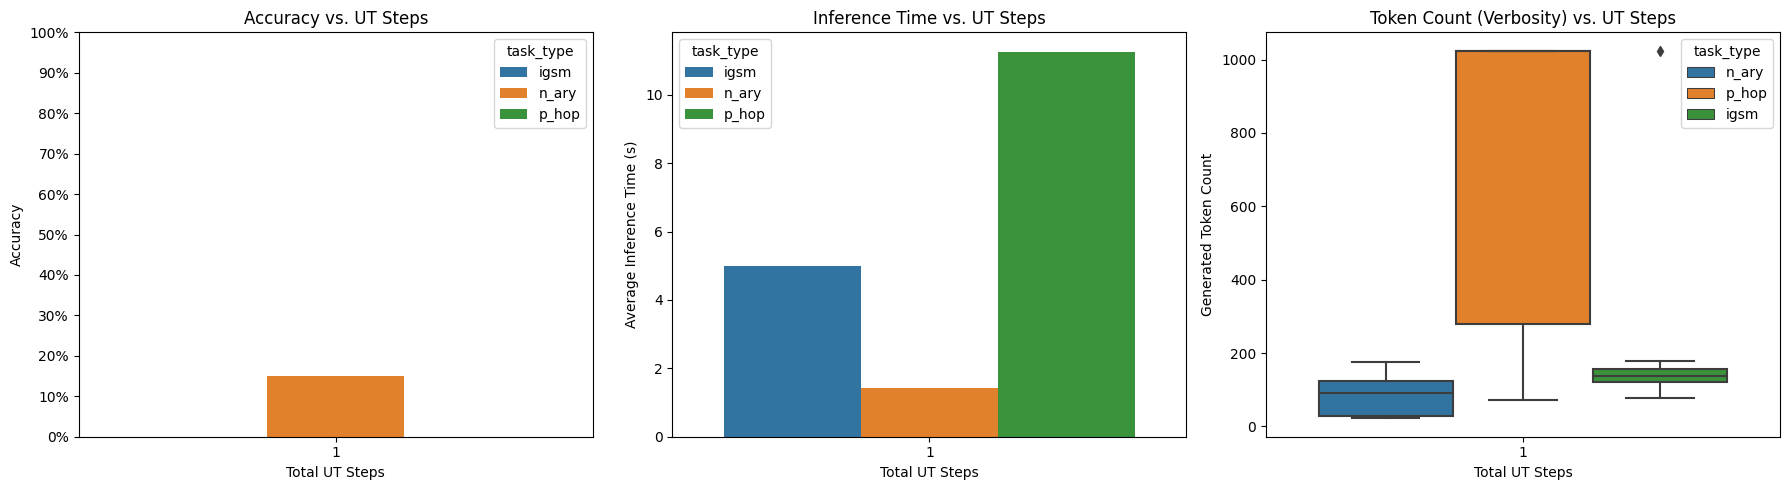

In [22]:
# ====================================================================
# IV. PHÂN TÍCH VÀ TRỰC QUAN HÓA
# ====================================================================

# Sử dụng df_acc từ Cell 6
if "df_acc" in locals() and not df_acc.empty:
    print("\n" + "=" * 50)
    print("VẼ ĐỒ THỊ TRỰC QUAN HÓA")
    print("=" * 50)

    # 1. Tạo báo cáo tóm tắt
    summary_report = (
        df_acc.groupby(["task_type", "difficulty", "ut_steps"])
        .agg(
            Accuracy=("is_correct", "mean"),
            Avg_Time=("generation_time", "mean"),
            Avg_Tokens=("generated_tokens", "mean"),
            Count=("test_id", "count"),
        )
        .reset_index()
    )

    print("--- BẢNG TÓM TẮT KẾT QUẢ THEO ĐỘ KHÓ VÀ UT STEPS ---")
    print(
        summary_report.to_markdown(index=False, floatfmt=(".2f", ".2%", ".2f", ".2f"))
    )

    # 2. Tạo báo cáo chung (không phân tách theo difficulty)
    overall_summary = (
        df_acc.groupby(["task_type", "ut_steps"])
        .agg(
            Accuracy=("is_correct", "mean"),
            Avg_Time=("generation_time", "mean"),
        )
        .reset_index()
    )

    print("\n--- BẢNG TÓM TẮT CHUNG (Task và UT Steps) ---")
    print(overall_summary.to_markdown(index=False, floatfmt=(".2%", ".2f")))

    # 3. Trực quan hóa dữ liệu
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot A: Accuracy vs UT Steps
    sns.barplot(
        data=overall_summary, x="ut_steps", y="Accuracy", hue="task_type", ax=axes[0]
    )
    axes[0].set_title("Accuracy vs. UT Steps")
    axes[0].set_xlabel("Total UT Steps")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_yticks([i / 10 for i in range(11)])
    axes[0].yaxis.set_major_formatter(
        plt.FuncFormatter(lambda y, _: "{:.0%}".format(y))
    )

    # Plot B: Inference Time vs UT Steps
    time_summary = (
        df_acc.groupby(["ut_steps", "task_type"])
        .agg(Avg_Time=("generation_time", "mean"))
        .reset_index()
    )
    sns.barplot(
        data=time_summary, x="ut_steps", y="Avg_Time", hue="task_type", ax=axes[1]
    )
    axes[1].set_title("Inference Time vs. UT Steps")
    axes[1].set_xlabel("Total UT Steps")
    axes[1].set_ylabel("Average Inference Time (s)")

    # Plot C: Verbosity (Tokens Generated)
    sns.boxplot(
        data=df_acc, x="ut_steps", y="generated_tokens", hue="task_type", ax=axes[2]
    )
    axes[2].set_title("Token Count (Verbosity) vs. UT Steps")
    axes[2].set_xlabel("Total UT Steps")
    axes[2].set_ylabel("Generated Token Count")

    plt.tight_layout()
    plt.show()

else:
    print("Không tìm thấy DataFrame kết quả (df_acc) để trực quan hóa.")

In [23]:
# TUTORIAL CODE FOR REFERENCE
import datasets
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.generation import GenerationConfig

model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen3-4B-Instruct-2507",
    attn_implementation="sdpa_paged",
    device_map="cuda",
    dtype=torch.bfloat16,
)
tokenizer = AutoTokenizer.from_pretrained(
    "Qwen/Qwen3-4B-Instruct-2507", padding_side="left"
)

dataset = datasets.load_dataset("openai/gsm8k", "socratic", split="test")
dataset = dataset.select(range(50))
tokenized_datasets = dataset.map(lambda x: tokenizer(x["question"]), batched=True)
simple_batch_inputs = [item["input_ids"] for item in tokenized_datasets]

generation_config = GenerationConfig(
    max_new_tokens=32,
    use_cuda_graph=False,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    do_sample=False,
    max_batch_tokens=512,
)

batch_outputs = model.generate_batch(
    inputs=simple_batch_inputs,
    generation_config=generation_config,
)

for request_id, output in batch_outputs.items():
    generated_text = tokenizer.decode(output.generated_tokens, skip_special_tokens=True)
    print(f"Request {request_id} output: {generated_text}")

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/99.6M [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

socratic/train-00000-of-00001.parquet:   0%|          | 0.00/2.68M [00:00<?, ?B/s]

socratic/test-00000-of-00001.parquet:   0%|          | 0.00/487k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Error in generation loop: CUDA out of memory. Tried to allocate 48.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 46.19 MiB is free. Process 12782 has 14.69 GiB memory in use. Of the allocated memory 14.53 GiB is allocated by PyTorch, and 24.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/transformers/generation/continuous_batching/continuous_api.py", line 671, in _run_generation_loop
    self._inner_generation_loop(batch_processor)
  File "/usr/local/lib/python3.11/dist-packages/transformers/utils/metrics.py", line 154, in wrapper
    result = func(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transform